In [1]:
### Necessary to allow loading of checkpoints ###
import os
import sys
sys.path.append(os.path.join('D:', os.sep, 'Users', 'Julien', 'Documents', 'GitHub', 'diploma_thesis', 'cnn'))
from collections import namedtuple
Genotype = namedtuple("Genotype", "normal normal_concat reduce reduce_concat")
###
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import torch
from datetime import timedelta
from matplotlib.ticker import MultipleLocator

# Constants

In [2]:
seeds = [42, 63]
gpu = "a100"
eval_epochs = [300, 600]

# Path to Checkpoints + Loading

In [3]:
ckpts = {
    seed: {
        epochs: torch.load(os.path.join("D:", os.sep, "DA_Results", "exp_2_extended_std_no_shuffle", gpu, f"gaussian_process-seed_{seed}-epochs_{epochs}", "outer_loop.ckpt"))
        for epochs in eval_epochs
    }
    for seed in seeds
}
stats = list(ckpts[63][300].keys())
random_samples = ckpts[63][300]['number_randomly_sampled']

for seed in seeds:
    for epochs in eval_epochs:
        if ckpts[seed][epochs]['learning_rates'].shape[0] > ckpts[seed][epochs]['valid_errors'].shape[0]:
            ckpts[seed][epochs]['learning_rates'] = ckpts[seed][epochs]['learning_rates'][:-1]

for seed in seeds:
    for epochs in eval_epochs:
        assert ckpts[seed][epochs]['learning_rates'].shape[0] == ckpts[seed][epochs]['valid_errors'].shape[0], f"{ckpts[seed][epochs]['learning_rates'].shape} vs {ckpts[seed][epochs]['valid_errors'].shape}"
#for seed in seeds:
#    for epochs in eval_epochs:
#        assert os.path.isfile(ckpts[seed][epochs]), f"Not a file: {ckpts[seed][epochs]}"

In [4]:
stats

['learning_rates',
 'valid_errors',
 'acquisition_values',
 'incumbent',
 'runtime',
 'number_randomly_sampled',
 'details',
 'rng_state',
 'searched_learning_rates']

In [12]:
print(ckpts[63][600]['learning_rates'][6])
#print(ckpts[42][600]['valid_errors'])
print(ckpts[63][600]['valid_errors'])

tensor([7.2912e-01, 4.2666e-01, 1.0000e-06, 9.7142e-01])
tensor([[3.8692],
        [3.7892],
        [4.0092],
        [3.6093],
        [4.0492],
        [4.3891],
        [3.3693],
        [3.6793],
        [3.5093],
        [3.9892],
        [3.8192],
        [3.7292],
        [3.5493],
        [3.8592],
        [3.5093]])


# Variables for plotting

In [6]:
GP_iterations = {
    epochs: {
        seed: np.arange(-random_samples, ckpts[seed][epochs]['learning_rates'].shape[0] - random_samples)
        for seed in seeds
    }
    for epochs in eval_epochs    
}

epochs_min_length = {
    epochs: min(ckpts[42][epochs]['valid_errors'].shape[0], ckpts[63][epochs]['valid_errors'].shape[0])
    for epochs in eval_epochs
}

valid_errors = {
    epochs: {
        'combined': np.concatenate(
            [ckpts[seed][epochs]['valid_errors'][:epochs_min_length[epochs]] for seed in seeds],
            axis=1
        )
    }
    for epochs in eval_epochs
}
for epochs in eval_epochs:
    valid_errors[epochs]['mean'] = np.mean(
        valid_errors[epochs]['combined'],
        axis=1
    )
    valid_errors[epochs]['std'] = np.std(
        valid_errors[epochs]['combined'],
        axis=1
    )
    
# get the learning rate candidates
learning_rates = {
    epochs: {
        seed: ckpts[]
    }
}

In [18]:
GP_iterations

{300: {42: array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
         13, 14, 15, 16, 17, 18]),
  63: array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
         13, 14, 15, 16, 17, 18, 19, 20, 21])},
 600: {42: array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
  63: array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}}

In [9]:
valid_errors

{300: {'combined': array([[3.8392334, 4.1791687],
         [4.759041 , 4.0091934],
         [3.5392914, 4.5490875],
         [4.3791275, 3.8092422],
         [3.5692825, 3.9992065],
         [4.209152 , 3.8692322],
         [3.7592468, 3.639267 ],
         [3.499298 , 3.5292816],
         [3.8392334, 3.7892456],
         [4.0691833, 3.6192703],
         [4.2791443, 3.7792435],
         [3.5492935, 4.299141 ],
         [3.8092422, 3.85923  ],
         [3.519287 , 4.3891144],
         [3.8392334, 4.1291656],
         [3.5492935, 4.02919  ],
         [3.7792435, 4.1291656],
         [4.069191 , 3.6092834],
         [3.5892792, 3.7592468],
         [3.4592972, 3.5692825],
         [4.3791275, 4.1491776],
         [3.7892456, 3.8192291],
         [3.699257 , 3.7792358]], dtype=float32),
  'mean': array([4.009201 , 4.384117 , 4.0441895, 4.094185 , 3.7842445, 4.039192 ,
         3.699257 , 3.5142899, 3.8142395, 3.8442268, 4.029194 , 3.9242172,
         3.8342361, 3.9542007, 3.9841995, 3.78924

# Plots

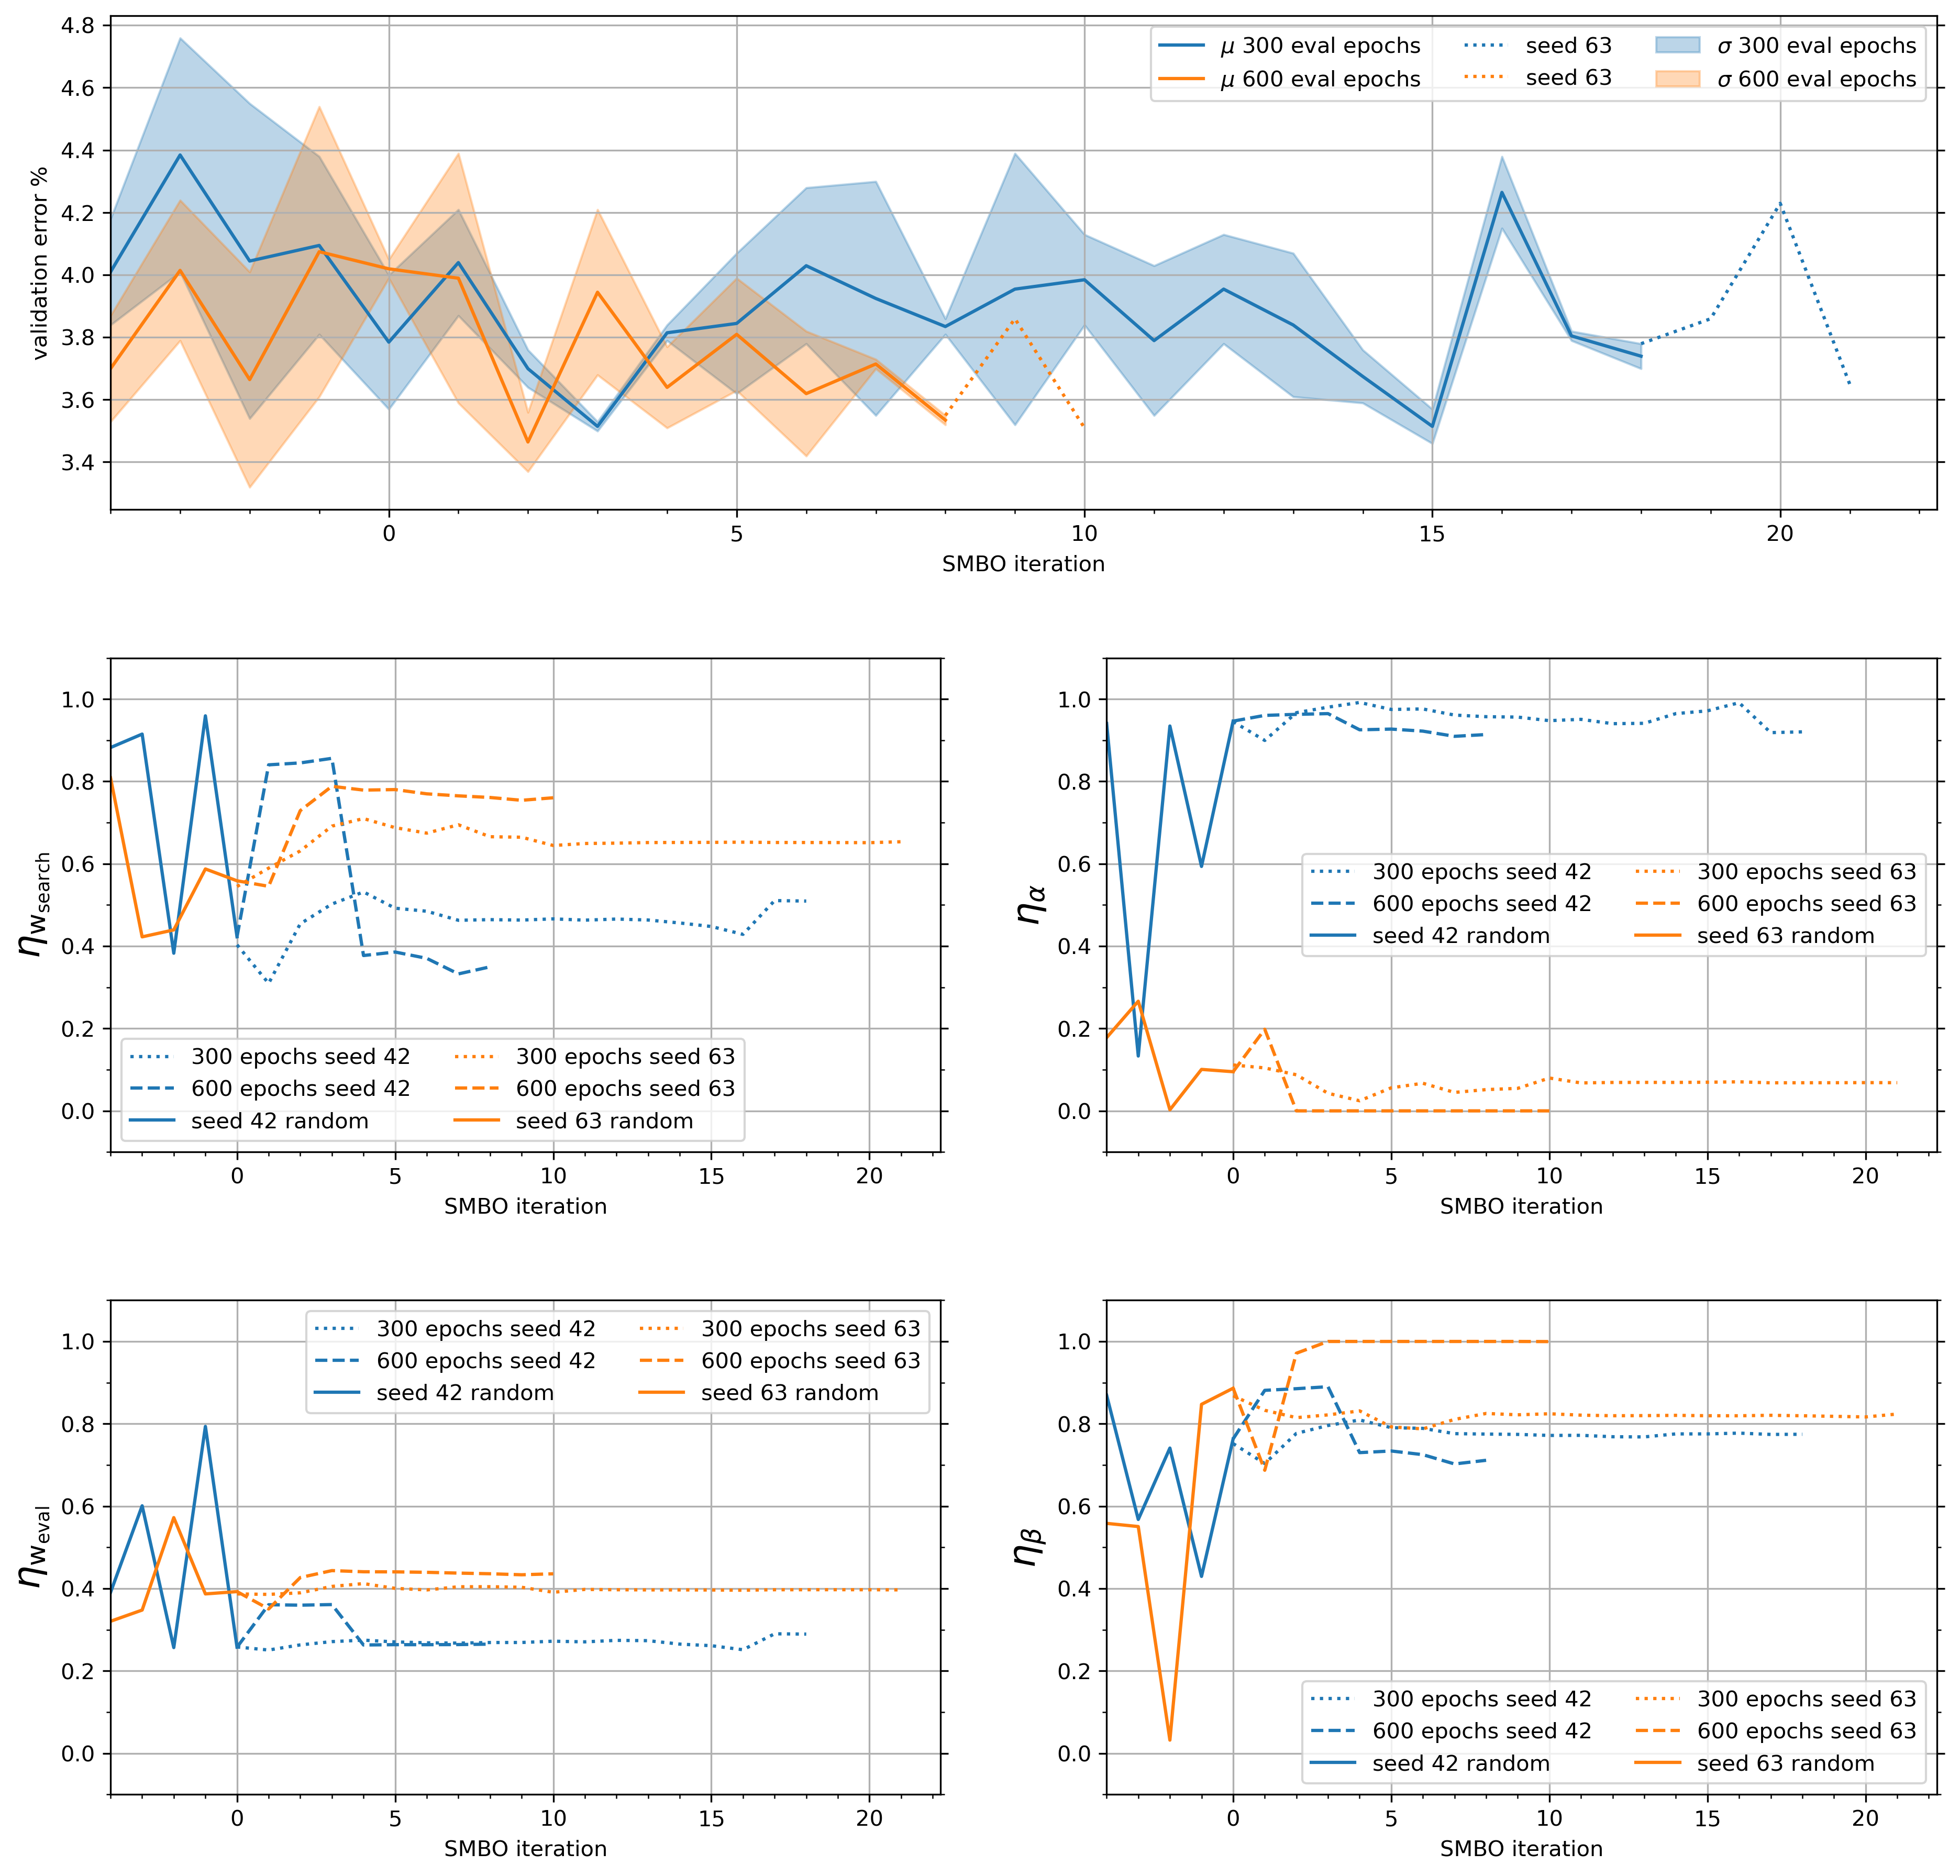

In [68]:
gs = GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1])
fig = plt.figure(figsize=(15,15), dpi=300)
plt.subplots_adjust(hspace=0.3)

error = fig.add_subplot(3,2, (1,2))
eta_w_search = fig.add_subplot(323)
eta_alpha = fig.add_subplot(324)
eta_w_eval = fig.add_subplot(325)
eta_beta = fig.add_subplot(326)
#model_weights = fig.add_subplot(427)
#architecture_weights = fig.add_subplot(428)

for ax in fig.get_axes():
    ax.grid()
    ax.yaxis.set_ticks_position('both')

error.set_ylabel('validation error %')
error.set_xlabel('SMBO iteration')
eta_w_search.set_ylabel(r"$\eta_\mathrm{w_{search}}$", fontsize="xx-large")
eta_w_search.set_xlabel("SMBO iteration")
eta_alpha.set_ylabel(r"$\eta_\alpha$", fontsize="xx-large")
eta_alpha.set_xlabel("SMBO iteration")
eta_w_eval.set_ylabel(r"$\eta_\mathrm{w_{eval}}$", fontsize="xx-large")
eta_w_eval.set_xlabel("SMBO iteration")
eta_beta.set_ylabel(r"$\eta_\beta$", fontsize="xx-large")
eta_beta.set_xlabel("SMBO iteration")
error.xaxis.set_minor_locator(MultipleLocator(1))
eta_w_search.yaxis.set_minor_locator(MultipleLocator(0.1))
eta_w_search.xaxis.set_minor_locator(MultipleLocator(1))
eta_alpha.yaxis.set_minor_locator(MultipleLocator(0.1))
eta_alpha.xaxis.set_minor_locator(MultipleLocator(1))
eta_w_eval.yaxis.set_minor_locator(MultipleLocator(0.1))
eta_w_eval.xaxis.set_minor_locator(MultipleLocator(1))
eta_beta.yaxis.set_minor_locator(MultipleLocator(0.1))
eta_beta.xaxis.set_minor_locator(MultipleLocator(1))


# plot train and validation error progression with GP iteration

error.plot(
    np.arange(-random_samples, valid_errors[300]['combined'].shape[0]-random_samples),
    valid_errors[300]['mean'],
    color="C0"
)
error.plot(
    np.arange(-random_samples, valid_errors[600]['combined'].shape[0]-random_samples),
    valid_errors[600]['mean'],
    color="C1"
)

error.fill_between(
    np.arange(-random_samples, valid_errors[300]['combined'].shape[0]-random_samples),
    valid_errors[300]['mean'] - valid_errors[300]['std'],
    valid_errors[300]['mean'] + valid_errors[300]['std'],
    alpha=0.3,
    color="C0"
)
error.fill_between(
    np.arange(-random_samples, valid_errors[600]['combined'].shape[0]-random_samples),
    valid_errors[600]['mean'] - valid_errors[600]['std'],
    valid_errors[600]['mean'] + valid_errors[600]['std'],
    alpha=0.3,
    color="C1"
)

error.plot(
    GP_iterations[300][63][epochs_min_length[300]-1:],
    ckpts[63][300]['valid_errors'][epochs_min_length[300]-1:].reshape(-1),
    color="C0",
    linestyle="dotted",
    label="seed 63"
)
error.plot(
    GP_iterations[600][63][epochs_min_length[600]-1:],
    ckpts[63][600]['valid_errors'][epochs_min_length[600]-1:].reshape(-1),
    color="C1",
    linestyle="dotted",
    label="seed 63"
)
#error.plot(
#    GP_iterations[300][42],
#    ckpts[42][300]['valid_errors'].reshape(-1),
#    color="C0",
#    linestyle="dashed"
#)
#error.plot(
#    GP_iterations[300][63],#[epochs_min_length[600]-1:],
#    ckpts[63][300]['valid_errors'].reshape(-1),#[epochs_min_length[600]-1:].reshape(-1),
#    color="k",
#    linestyle="dotted",
#    label="_nolegend_"
#)

error.set_xlim(left=-4)
error.legend(
    [
        r"$\mu$ 300 eval epochs",
        r"$\mu$ 600 eval epochs",
        "seed 63",
        "seed 63",
        r"$\sigma$ 300 eval epochs",
        r"$\sigma$ 600 eval epochs"
    ],
    ncol=3
)

# plot eta_w_search progression
eta_w_search.plot(
    GP_iterations[300][42][random_samples:],
    ckpts[42][300]['learning_rates'][random_samples:, 0],
    linestyle="dotted",
    color="C0",
    label="300 epochs seed 42"
)
eta_w_search.plot(
    GP_iterations[600][42][random_samples:],
    ckpts[42][600]['learning_rates'][random_samples:, 0],
    linestyle="dashed",
    color="C0",
    label="600 epochs seed 42"
)
eta_w_search.plot(
    np.arange(-random_samples, 1),
    ckpts[42][600]['learning_rates'][:random_samples+1, 0],
    linestyle="solid",
    color="C0",
    label="seed 42 random"
)
eta_w_search.plot(
    GP_iterations[300][63][random_samples:],
    ckpts[63][300]['learning_rates'][random_samples:, 0],
    linestyle="dotted",
    color="C1",
    label="300 epochs seed 63"
)
eta_w_search.plot(
    GP_iterations[600][63][random_samples:],
    ckpts[63][600]['learning_rates'][random_samples:, 0],
    linestyle="dashed",
    color="C1",
    label="600 epochs seed 63"
)
eta_w_search.plot(
    np.arange(-random_samples, 1),
    ckpts[63][600]['learning_rates'][:random_samples+1, 0],
    linestyle="solid",
    color="C1",
    label="seed 63 random"
)
eta_w_search.legend(ncol=2)

# plot eta_alpha progression
eta_alpha.plot(
    GP_iterations[300][42][random_samples:],
    ckpts[42][300]['learning_rates'][random_samples:, 2],
    linestyle="dotted",
    color="C0",
    label="300 epochs seed 42"
)
eta_alpha.plot(
    GP_iterations[600][42][random_samples:],
    ckpts[42][600]['learning_rates'][random_samples:, 2],
    linestyle="dashed",
    color="C0",
    label="600 epochs seed 42"
)
eta_alpha.plot(
    np.arange(-random_samples, 1),
    ckpts[42][600]['learning_rates'][:random_samples+1, 2],
    linestyle="solid",
    color="C0",
    label="seed 42 random"
)
eta_alpha.plot(
    GP_iterations[300][63][random_samples:],
    ckpts[63][300]['learning_rates'][random_samples:, 2],
    linestyle="dotted",
    color="C1",
    label="300 epochs seed 63"
)
eta_alpha.plot(
    GP_iterations[600][63][random_samples:],
    ckpts[63][600]['learning_rates'][random_samples:, 2],
    linestyle="dashed",
    color="C1",
    label="600 epochs seed 63"
)
eta_alpha.plot(
    np.arange(-random_samples, 1),
    ckpts[63][600]['learning_rates'][:random_samples+1, 2],
    linestyle="solid",
    color="C1",
    label="seed 63 random"
)
eta_alpha.legend(ncol=2)

# plot eta_w_eval progression
eta_w_eval.plot(
    GP_iterations[300][42][random_samples:],
    ckpts[42][300]['learning_rates'][random_samples:, 1],
    linestyle="dotted",
    color="C0",
    label="300 epochs seed 42"
)
eta_w_eval.plot(
    GP_iterations[600][42][random_samples:],
    ckpts[42][600]['learning_rates'][random_samples:, 1],
    linestyle="dashed",
    color="C0",
    label="600 epochs seed 42"
)
eta_w_eval.plot(
    np.arange(-random_samples, 1),
    ckpts[42][600]['learning_rates'][:random_samples+1, 1],
    linestyle="solid",
    color="C0",
    label="seed 42 random"
)
eta_w_eval.plot(
    GP_iterations[300][63][random_samples:],
    ckpts[63][300]['learning_rates'][random_samples:, 1],
    linestyle="dotted",
    color="C1",
    label="300 epochs seed 63"
)
eta_w_eval.plot(
    GP_iterations[600][63][random_samples:],
    ckpts[63][600]['learning_rates'][random_samples:, 1],
    linestyle="dashed",
    color="C1",
    label="600 epochs seed 63"
)
eta_w_eval.plot(
    np.arange(-random_samples, 1),
    ckpts[63][600]['learning_rates'][:random_samples+1, 1],
    linestyle="solid",
    color="C1",
    label="seed 63 random"
)
eta_w_eval.legend(ncol=2)

# plot eta_beta
eta_beta.plot(
    GP_iterations[300][42][random_samples:],
    ckpts[42][300]['learning_rates'][random_samples:, 3],
    linestyle="dotted",
    color="C0",
    label="300 epochs seed 42"
)
eta_beta.plot(
    GP_iterations[600][42][random_samples:],
    ckpts[42][600]['learning_rates'][random_samples:, 3],
    linestyle="dashed",
    color="C0",
    label="600 epochs seed 42"
)
eta_beta.plot(
    np.arange(-random_samples, 1),
    ckpts[42][600]['learning_rates'][:random_samples+1, 3],
    linestyle="solid",
    color="C0",
    label="seed 42 random"
)
eta_beta.plot(
    GP_iterations[300][63][random_samples:],
    ckpts[63][300]['learning_rates'][random_samples:, 3],
    linestyle="dotted",
    color="C1",
    label="300 epochs seed 63"
)
eta_beta.plot(
    GP_iterations[600][63][random_samples:],
    ckpts[63][600]['learning_rates'][random_samples:, 3],
    linestyle="dashed",
    color="C1",
    label="600 epochs seed 63"
)
eta_beta.plot(
    np.arange(-random_samples, 1),
    ckpts[63][600]['learning_rates'][:random_samples+1, 3],
    linestyle="solid",
    color="C1",
    label="seed 63 random"
)
eta_beta.legend(ncol=2)

#error.set_ylim(bottom=0)
eta_w_search.set_ylim(bottom=-0.1, top=1.1)
eta_w_search.set_xlim(left=-random_samples)
eta_alpha.set_ylim(bottom=-0.1, top=1.1)
eta_alpha.set_xlim(left=-random_samples)
eta_w_eval.set_ylim(bottom=-0.1, top=1.1)
eta_w_eval.set_xlim(left=-random_samples)
eta_beta.set_ylim(bottom=-0.1, top=1.1)
eta_beta.set_xlim(left=-random_samples)

plt.savefig("images/exp_2_smbo_iterations.svg", bbox_inches="tight")

plt.show()

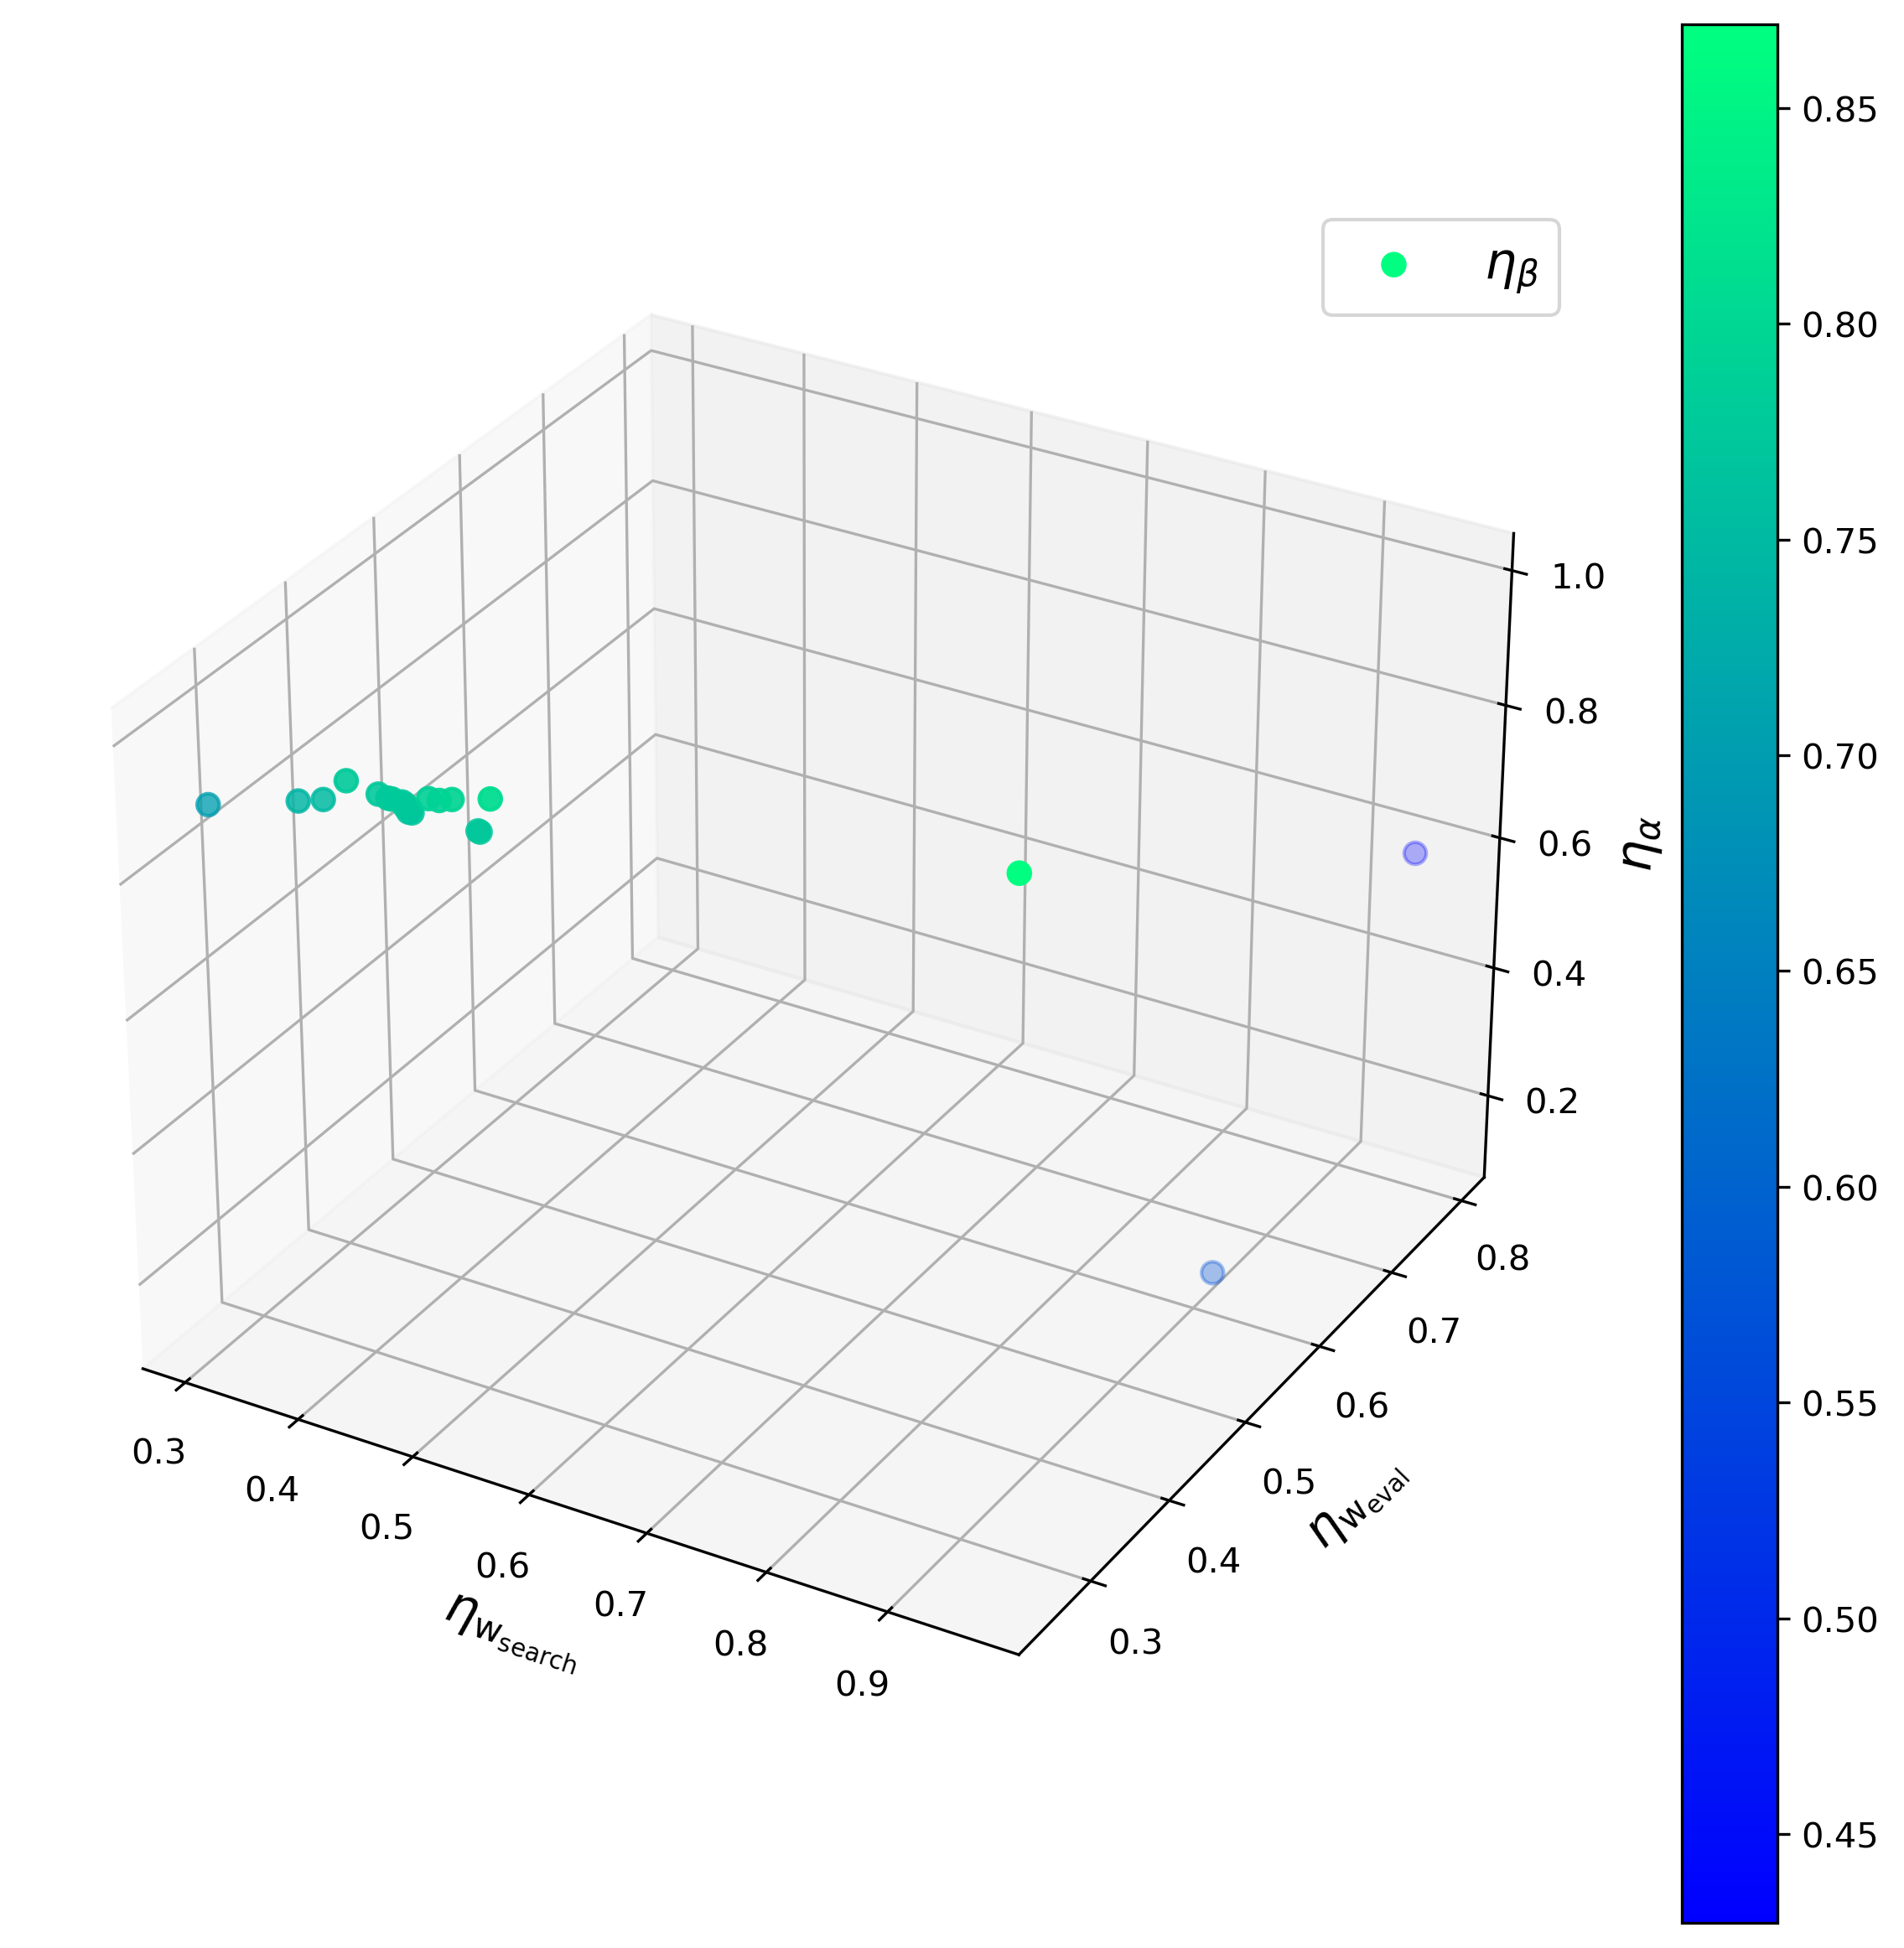

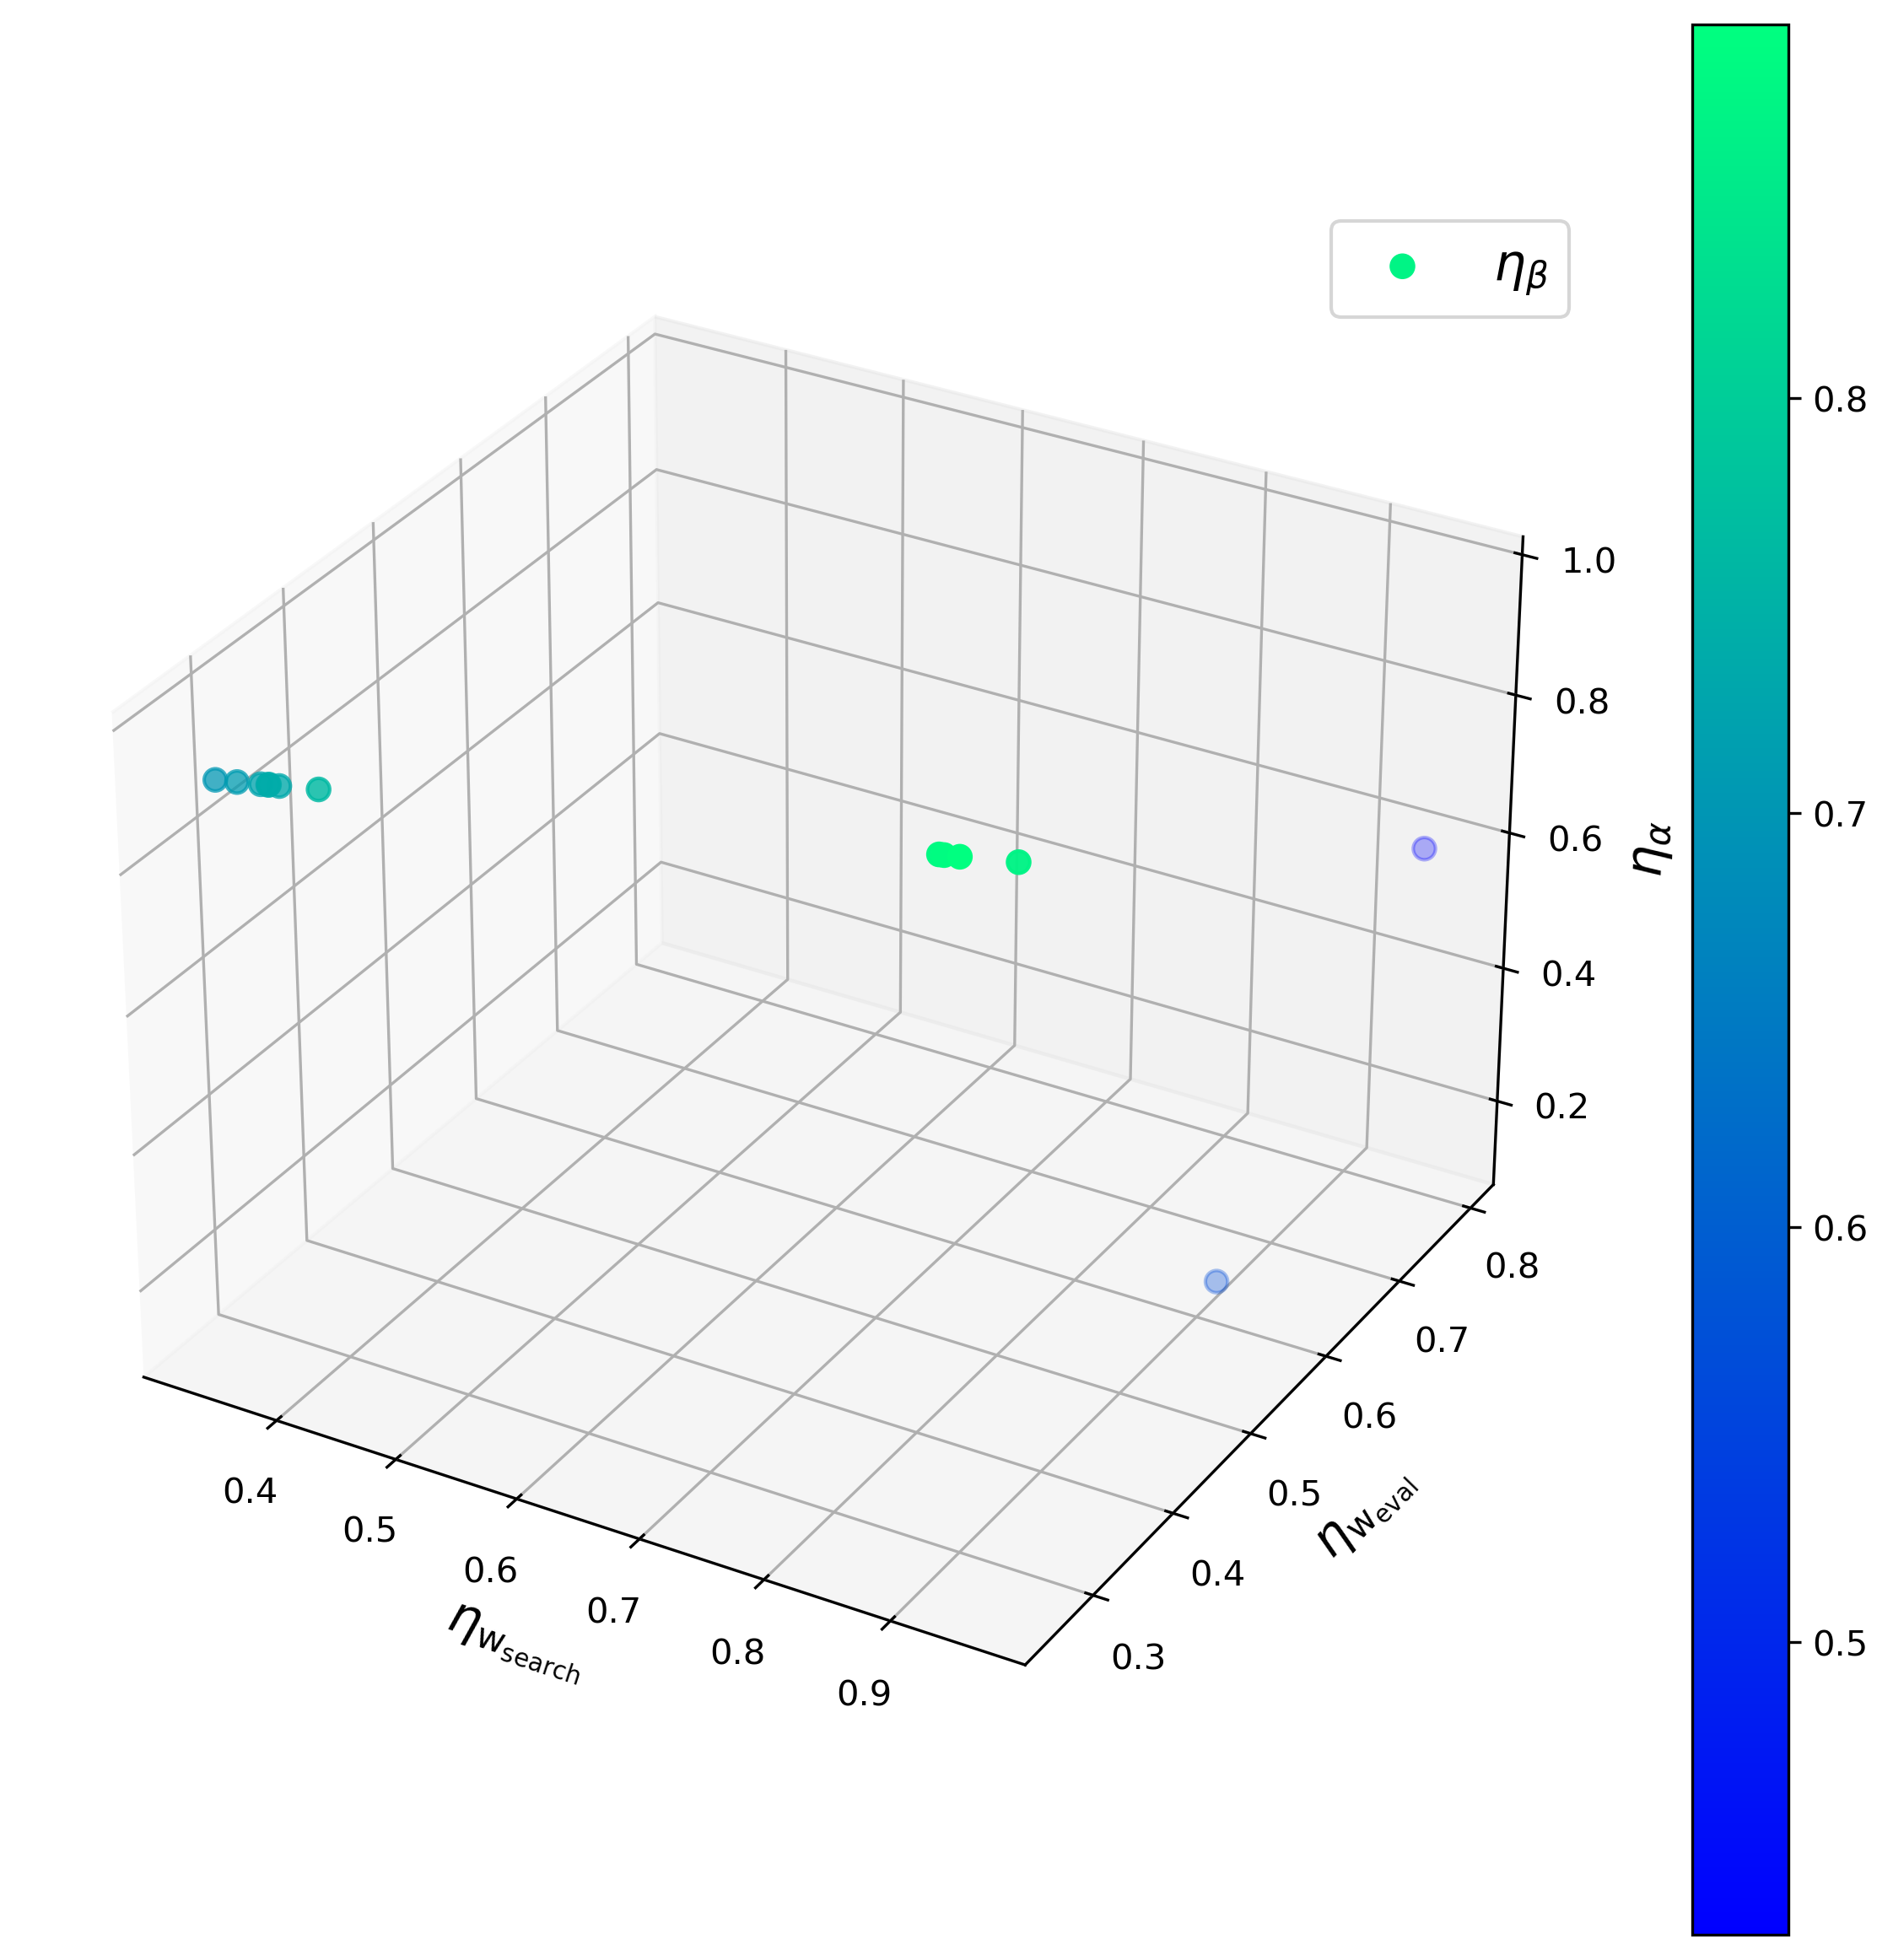

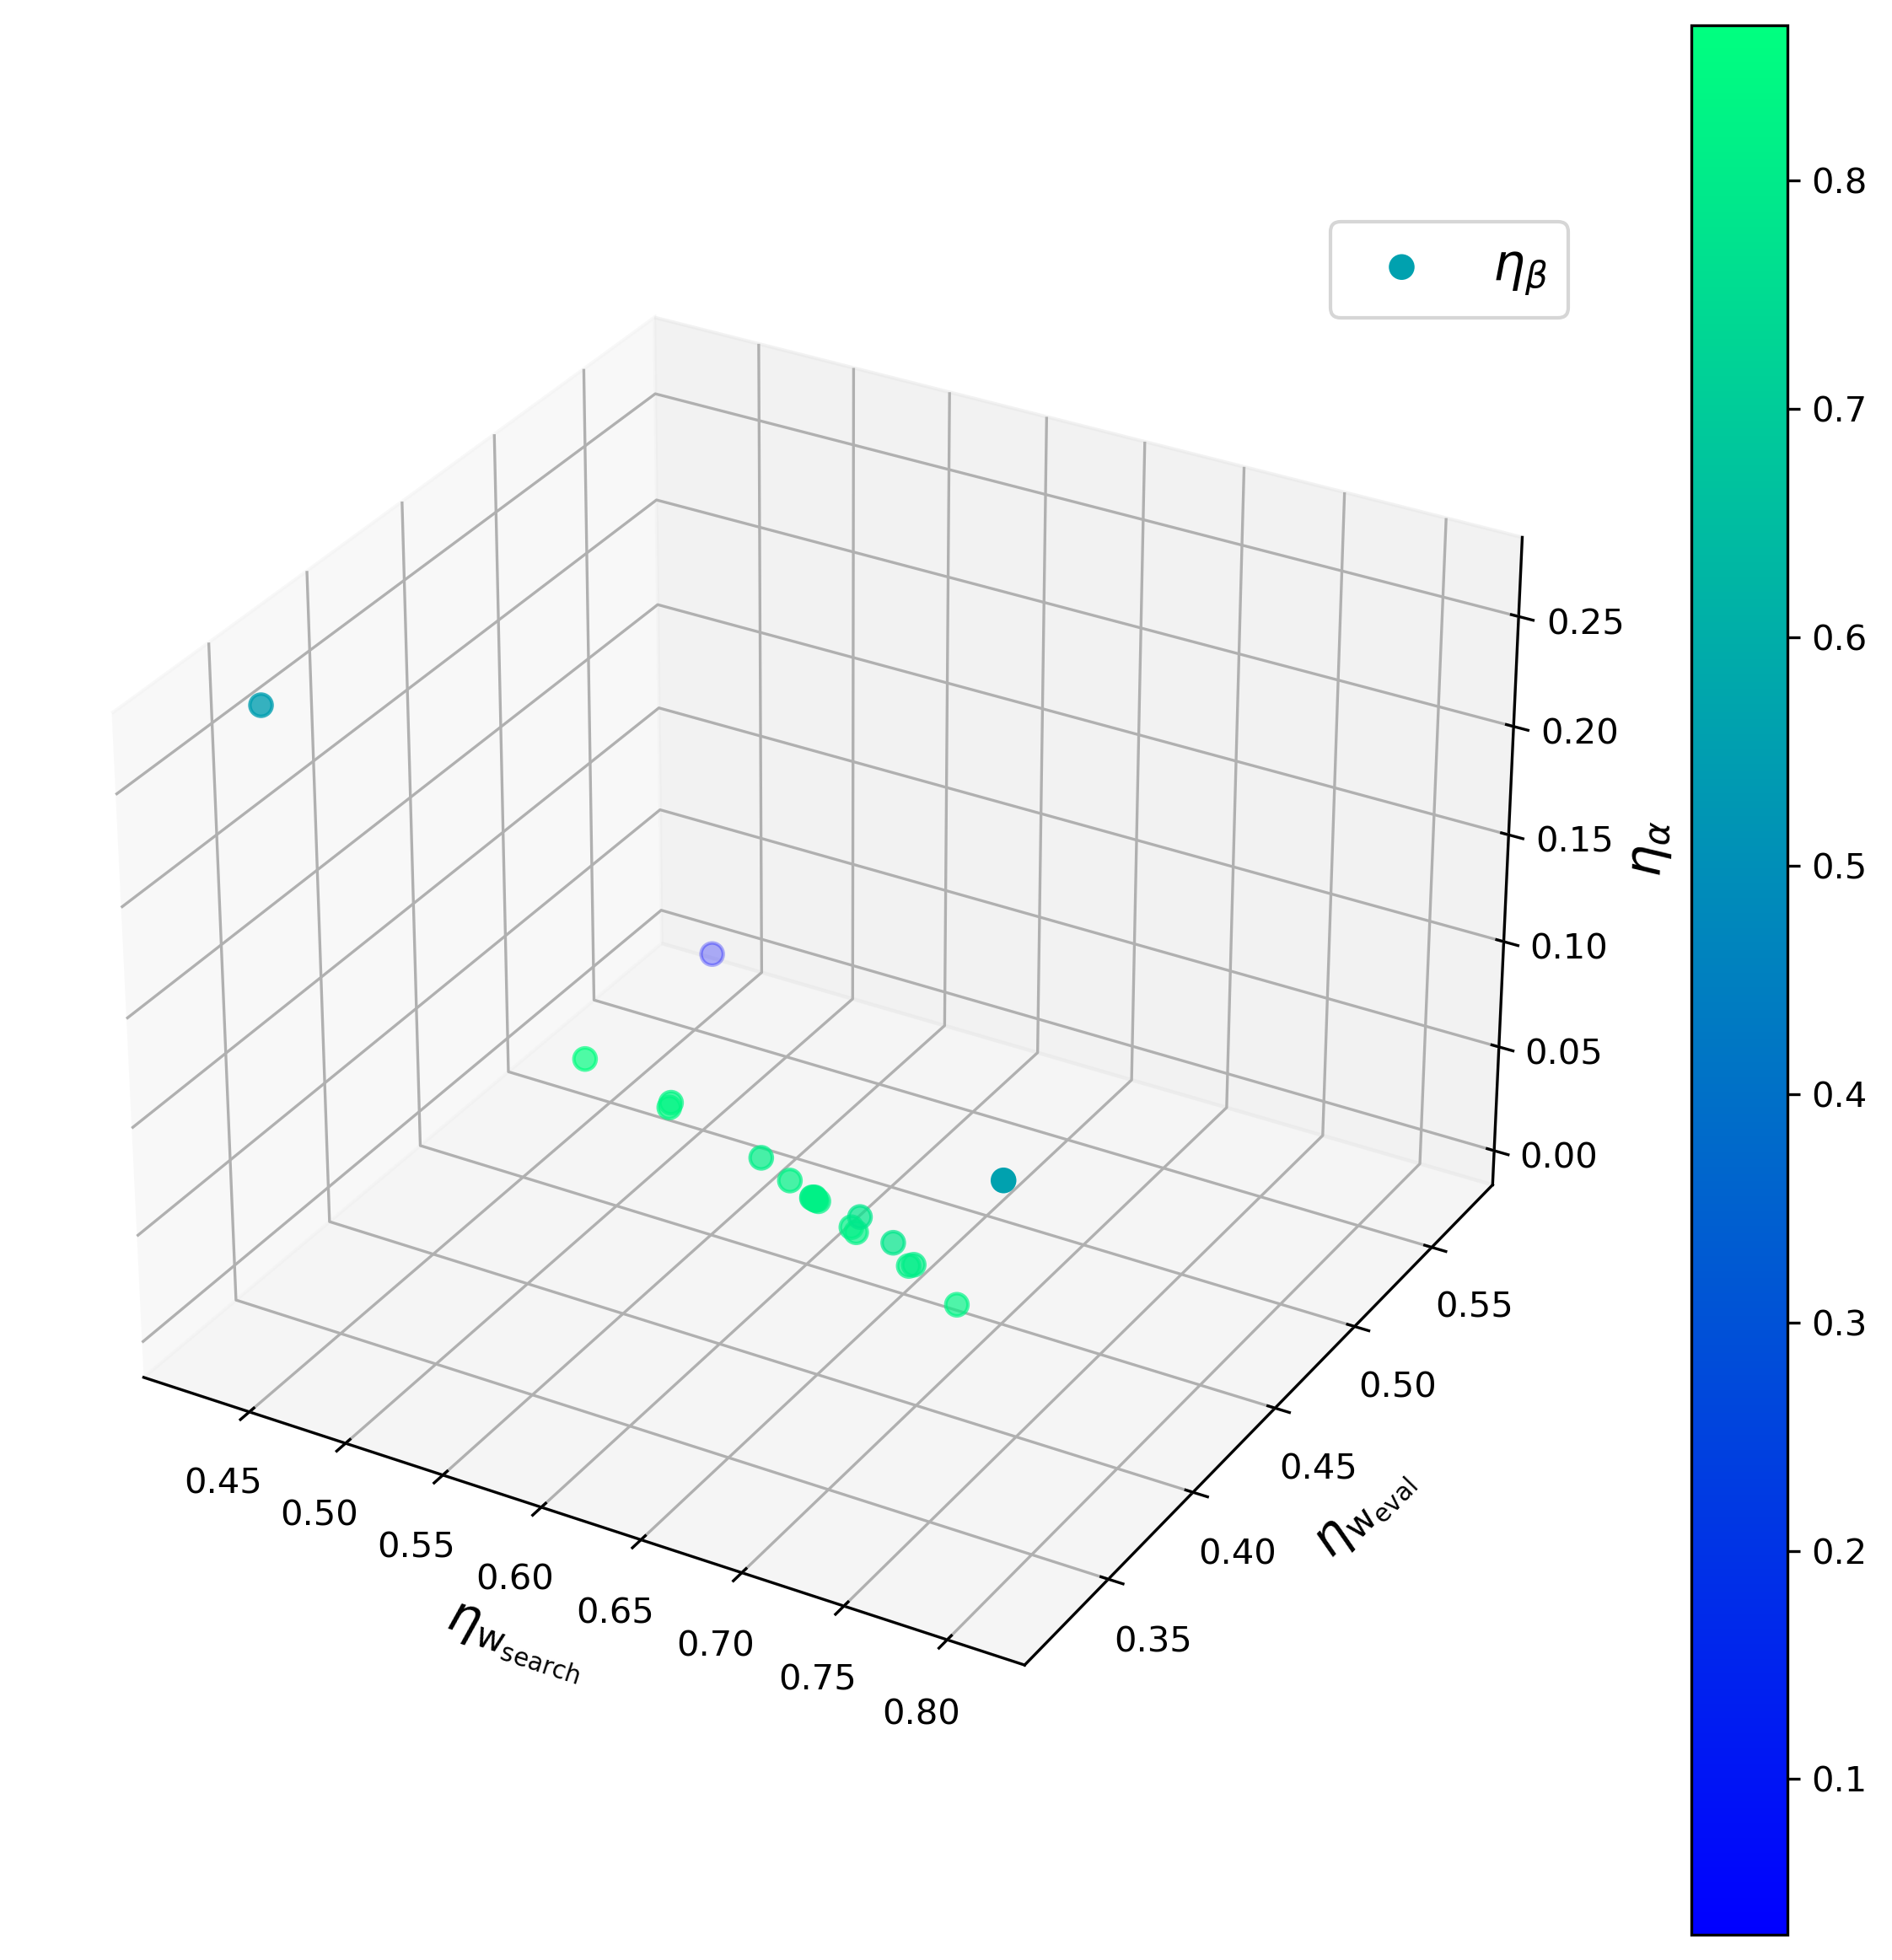

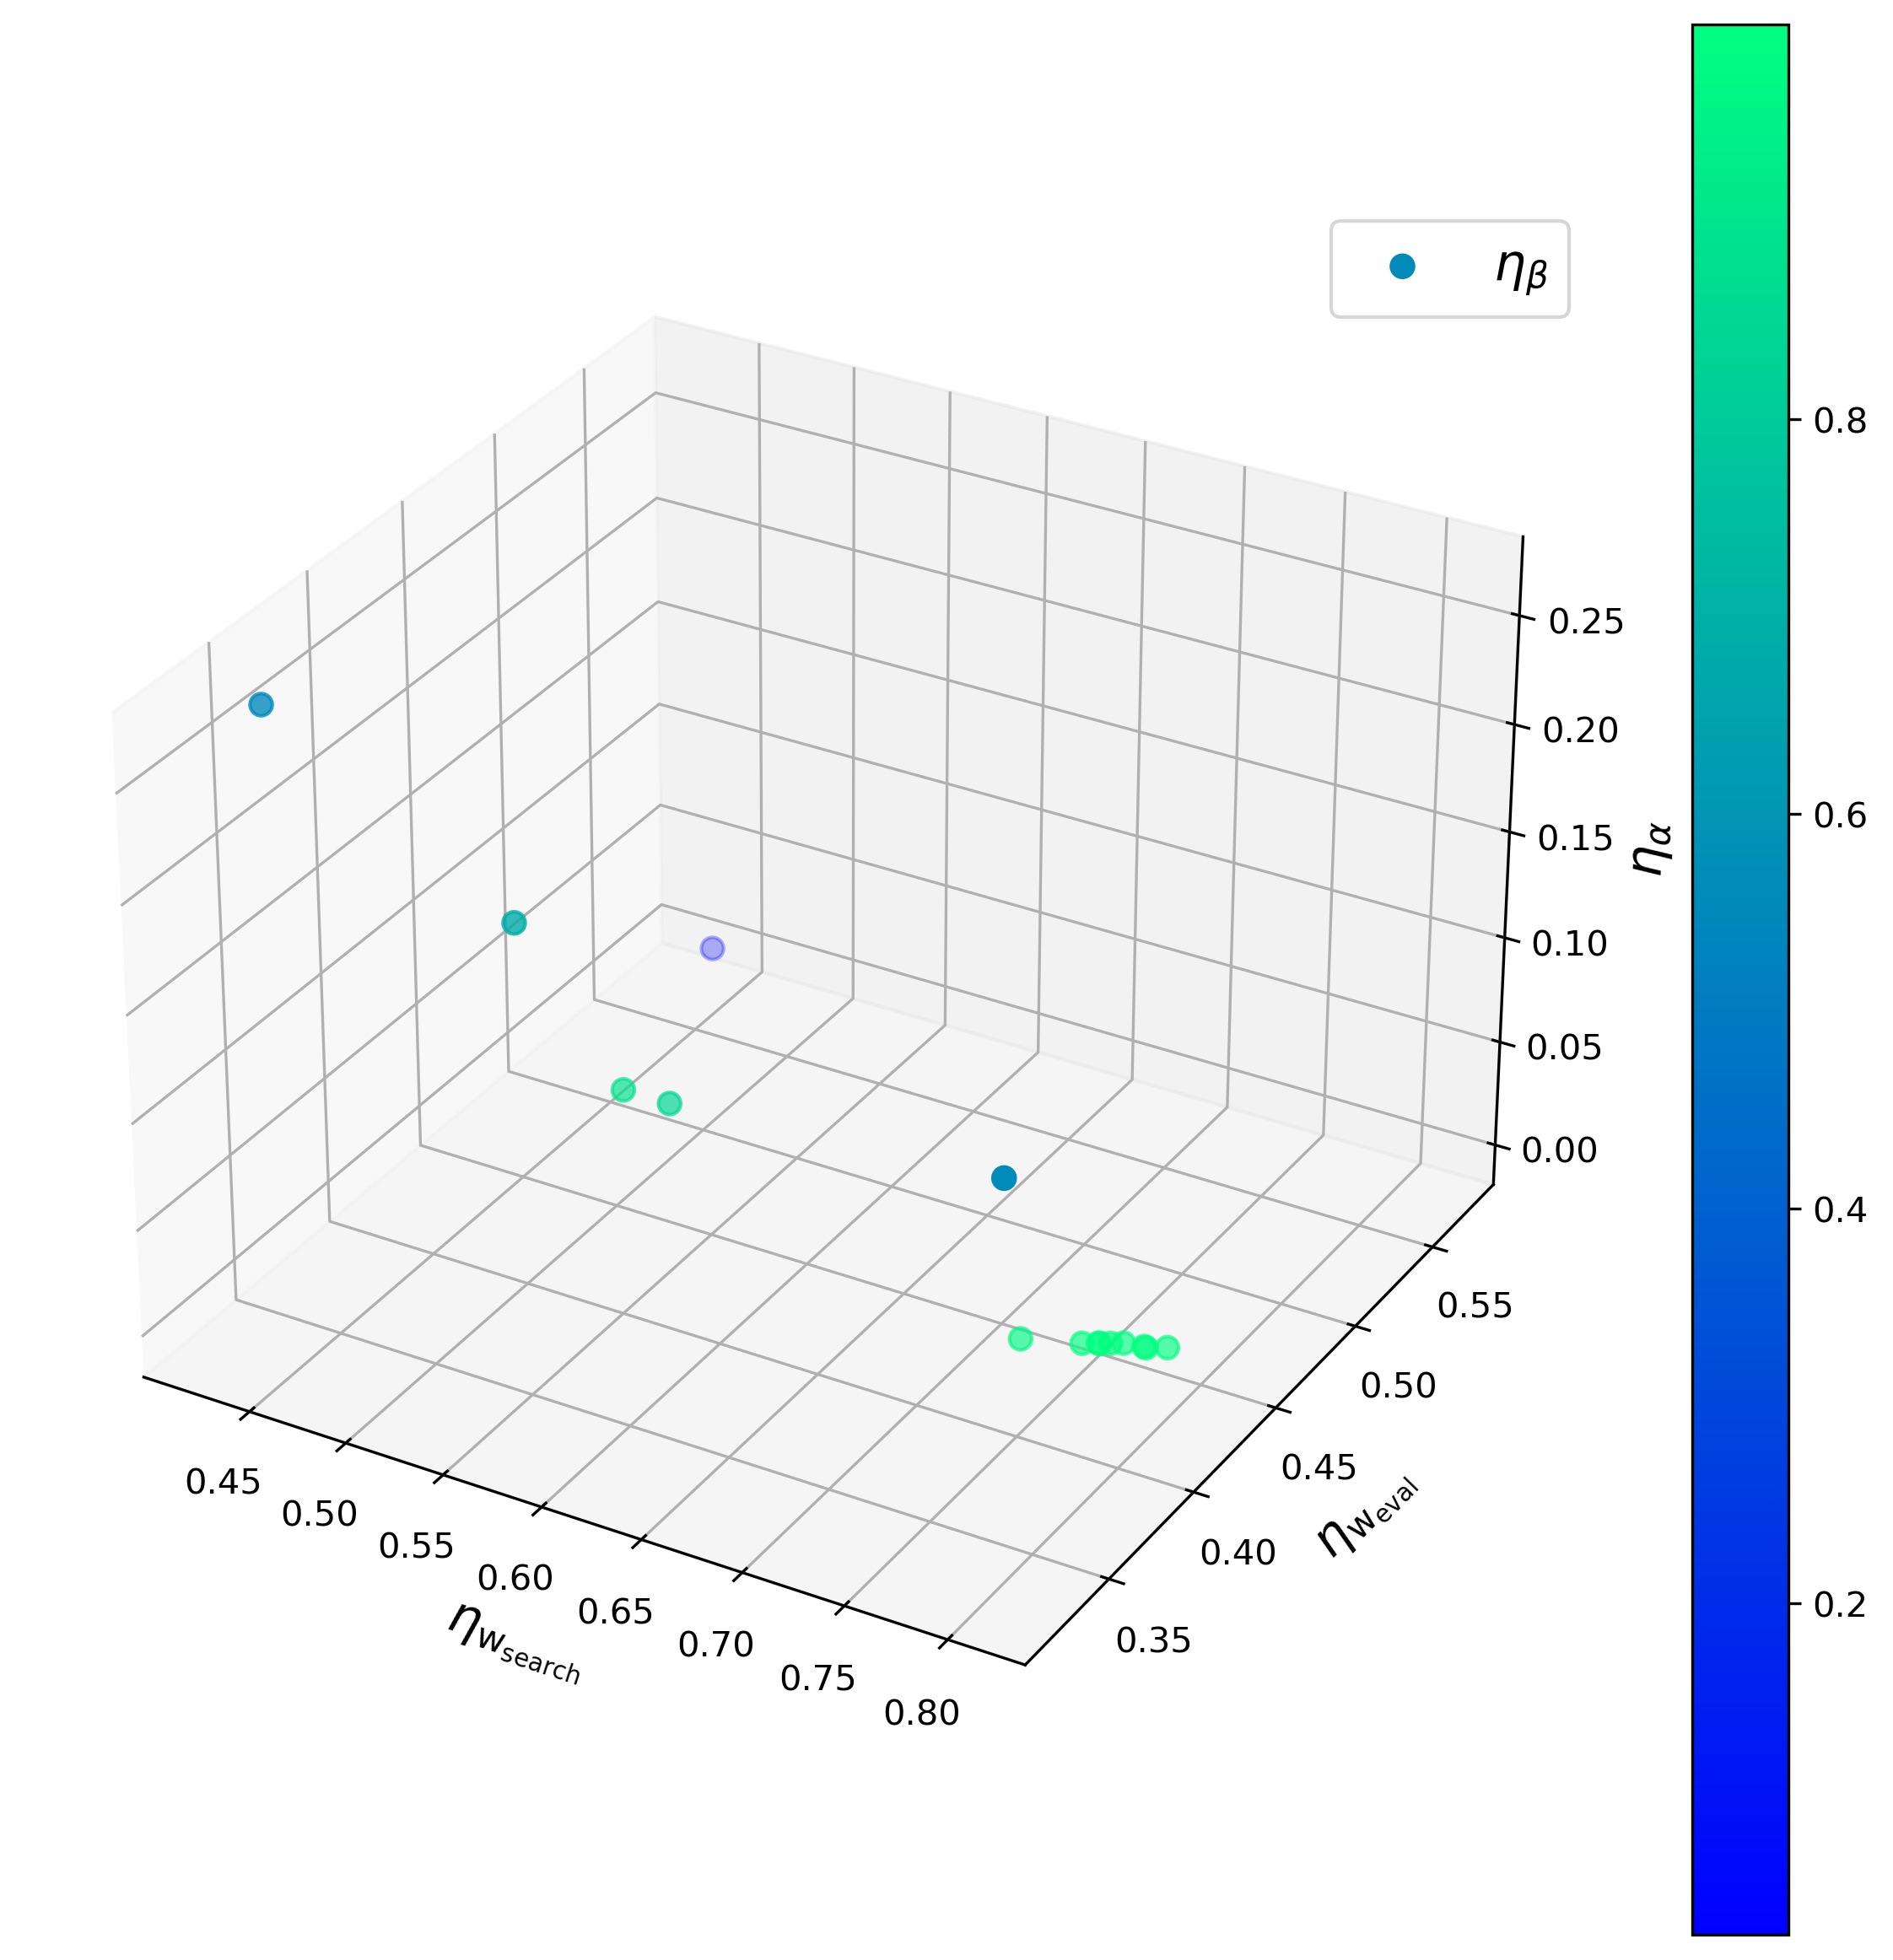

In [112]:
for seed in [42, 63]:
    for epochs in [300, 600]:
        fig = plt.figure(figsize=(10,10), dpi=300)
        ax = fig.add_subplot(111, projection='3d')

        img = ax.scatter(
            ckpts[seed][epochs]['learning_rates'][:, 0], 
            ckpts[seed][epochs]['learning_rates'][:, 1], 
            ckpts[seed][epochs]['learning_rates'][:, 2], 
            c=ckpts[seed][epochs]['learning_rates'][:, 3], 
            cmap="winter", 
            marker="o", 
            s=40
        )
        ax.set_xlabel(r"$\eta_\mathrm{w_{search}}$", fontsize="x-large")
        ax.set_ylabel(r"$\eta_\mathrm{w_{eval}}$", fontsize="x-large")
        ax.set_zlabel(r"$\eta_\alpha$", fontsize="x-large")
        ax.legend([r"$\eta_\beta$"], fontsize="x-large")
        fig.colorbar(img)
        
        plt.savefig(f"images/exp_2_distribution_seed_{seed}_epochs_{epochs}.svg", bbox_inches="tight")

        plt.show()

In [51]:
ckpts[63][300]['learning_rates'][:, 2]

tensor([0.1779, 0.2663, 0.0026, 0.1007, 0.1115, 0.1043, 0.0876, 0.0427, 0.0245,
        0.0560, 0.0670, 0.0448, 0.0516, 0.0546, 0.0797, 0.0678, 0.0690, 0.0691,
        0.0691, 0.0696, 0.0705, 0.0681, 0.0682, 0.0683, 0.0686, 0.0684])

In [19]:
ckpts[63][300]['learning_rates']

tensor([[0.8089, 0.3205, 0.1779, 0.5582],
        [0.4226, 0.3477, 0.2663, 0.5505],
        [0.4395, 0.5722, 0.0026, 0.0318],
        [0.5875, 0.3869, 0.1007, 0.8473],
        [0.5448, 0.3869, 0.1115, 0.8681],
        [0.5895, 0.3857, 0.1043, 0.8328],
        [0.6313, 0.3896, 0.0876, 0.8150],
        [0.6915, 0.4051, 0.0427, 0.8217],
        [0.7098, 0.4119, 0.0245, 0.8314],
        [0.6878, 0.4004, 0.0560, 0.7925],
        [0.6745, 0.3966, 0.0670, 0.7877],
        [0.6947, 0.4042, 0.0448, 0.8106],
        [0.6657, 0.4044, 0.0516, 0.8251],
        [0.6645, 0.4030, 0.0546, 0.8219],
        [0.6444, 0.3909, 0.0797, 0.8244],
        [0.6493, 0.3978, 0.0678, 0.8210],
        [0.6502, 0.3971, 0.0690, 0.8196],
        [0.6516, 0.3967, 0.0691, 0.8199],
        [0.6518, 0.3966, 0.0691, 0.8205],
        [0.6520, 0.3964, 0.0696, 0.8196],
        [0.6525, 0.3959, 0.0705, 0.8195],
        [0.6517, 0.3971, 0.0681, 0.8206],
        [0.6517, 0.3971, 0.0682, 0.8195],
        [0.6516, 0.3972, 0.0683, 0

In [90]:
epochs_min_length

{300: 23, 600: 13}